In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import numpy
import scipy
import math
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import sys
import os
import socket
#import lmod
# lmod.load('system')
# lmod.load('texlive')
# lmod.
#
# TODO: phase out unreferenced hpc_lib calls...
import hpc_lib
import hpc_reports
#
# def running_mean(X,n=10):
#     return (numpy.cumsum(numpy.insert(X,0,0))[n:] - numpy.cumsum(numpy.insert(X,0,0))[:-n])/n
# #

In [11]:
n_cpus = 4
print('** epoch: {}'.format(mpd.get_epoch()))


** epoch: 1970-01-01T00:00:00


In [12]:
N_report_len = 180
end_dtm = dtm.datetime(2022,7,6)
end_date = end_dtm.date()
start_date = end_date - dtm.timedelta(days=N_report_len)
print('*** dates: {} - {}'.format(start_date, end_date))
partition='serc'
#partition=None
group=None
s_user=None
verbose=0
# group='oneillm'
# group='edunham'
#s_user = 'labraha2'
#
sacct_h5_file = f'sacct_data/sacct_p{str(partition).upper()}_g{str(group).upper()}_u{s_user}_{start_date.year:04}{start_date.month:02}{start_date.day:02}_{end_dtm.year:04}{end_dtm.month:02}{end_dtm.day:02}.h5'
print(f'*** sacct_h5_file: {sacct_h5_file}')

*** dates: 2022-01-07 - 2022-07-06
*** sacct_h5_file: sacct_data/sacct_pSERC_gNONE_uNone_20220107_20220706.h5


In [7]:
# NOTE: to get individual users, eg to get Eric's group usage:
#. sacct --allusers --user=labraha2 --start=2022-01-01 --end=2022-06-15
#
# NOTE: additional options can be passed in the more_options=[] arrary, or just as sacct_{option-name}={val}
#
if os.path.isfile(sacct_h5_file):
    print('*** Creating SACCT object from HDF5 {}'.format(sacct_h5_file))
    SACCT_obj = hpc_lib.SACCT_data_from_h5(sacct_h5_file, keep_raw_data=False, n_cpu=n_cpus)
    #
    
else:
    print('*** Fetching SACCT data directly')
    SACCT_obj = hpc_lib.SACCT_data_direct(group=group, partition=partition, start_date=str(start_date),
                                          n_cpu=n_cpus, verbose=verbose,
                                          end_date=str(end_date), keep_raw_data=False)
    # , sacct_user=s_user
    print(f'** writing HDF5: {sacct_h5_file}')
    SACCT_obj.write_hdf5(sacct_h5_file)
    #
#
print('** ', SACCT_obj.jobs_summary.dtype.names)

*** Creating SACCT object from HDF5 sacct_data/sacct_pSERC_gNONE_uNone_20220107_20220706.h5
**  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize', 'MaxDiskWrite', 'MaxDiskRead', 'AveDiskWrite', 'AveDiskRead', 'JobID_parent')


In [8]:
# # check date epoch:
# dt_test = SACCT_obj.jobs_summary['Start'][0]
# yr_test = mpd.num2date(dt_test).year
# print(f'** yr_test: {yr_test}')
# #print('** ', mpd.num2epoch(dt_test))
# if yr_test>3000:
#     mpd.set_epoch('0000-12-31T00:00:00')
# yr_test = mpd.num2date(dt_test)
# print(f'** yr_test: {yr_test}')

In [34]:
cpuh_layers = SACCT_obj.get_cpu_hours_layer_cake(bin_size=1., layer_field='Group')

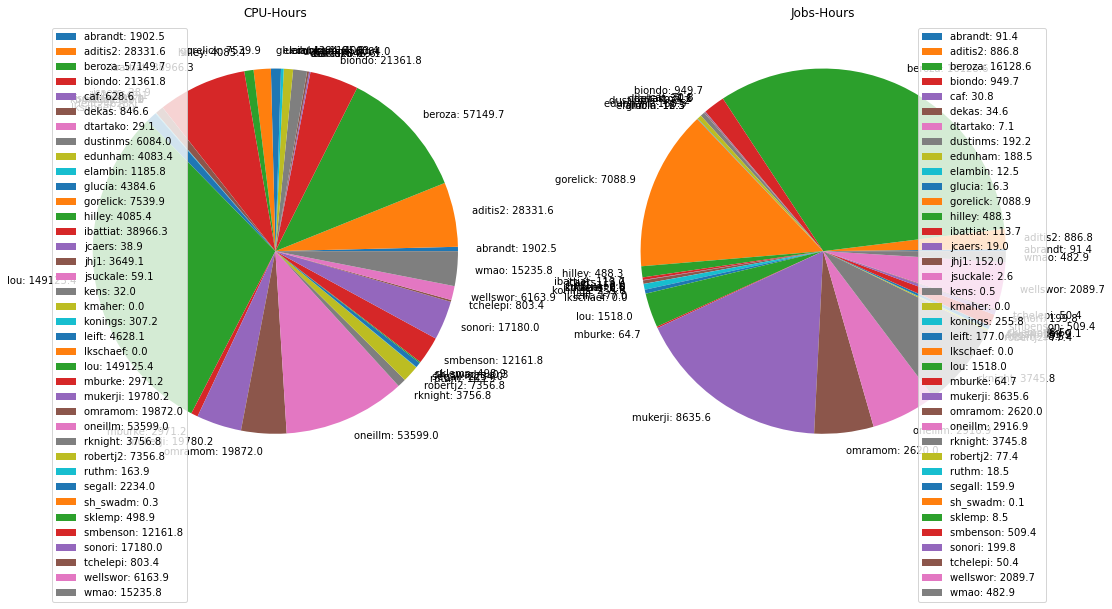

In [35]:


#
#pi_slices = hpc_lib.get_pie_slices(SACCT_obj.jobs_summary['Elapsed'], SACCT_obj.jobs_summary['Partition'])
fg = plt.figure(figsize=(18,10))
ax1 = fg.add_subplot(1,2,1)
ax2 = fg.add_subplot(1,2,2)
#
ax1.set_title('CPU-Hours')
ax2.set_title('Jobs-Hours')
#
pie_cpuh_data = hpc_lib.plot_pie(sum_data=SACCT_obj.jobs_summary['Elapsed']*SACCT_obj.jobs_summary['NCPUS'],
                                slice_data=SACCT_obj.jobs_summary['Group'], 
                            ax=ax1
                                )
#pi_slices = ax.pie(pi_slices[:,1], labels=pi_slices[:,0])
pie_jobs_data = hpc_lib.plot_pie(sum_data=SACCT_obj.jobs_summary['Elapsed'], 
                            slice_data=SACCT_obj.jobs_summary['Group'], 
                            ax=ax2)
ax1.legend(loc=0)
ax2.legend(loc=0)



/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:3023: UserWarning: FixedFormatter should only be used together with FixedLocator
  return numpy.array([T,z]).transpose()
/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:3023: UserWarning: FixedFormatter should only be used together with FixedLocator
  return numpy.array([T,z]).transpose()


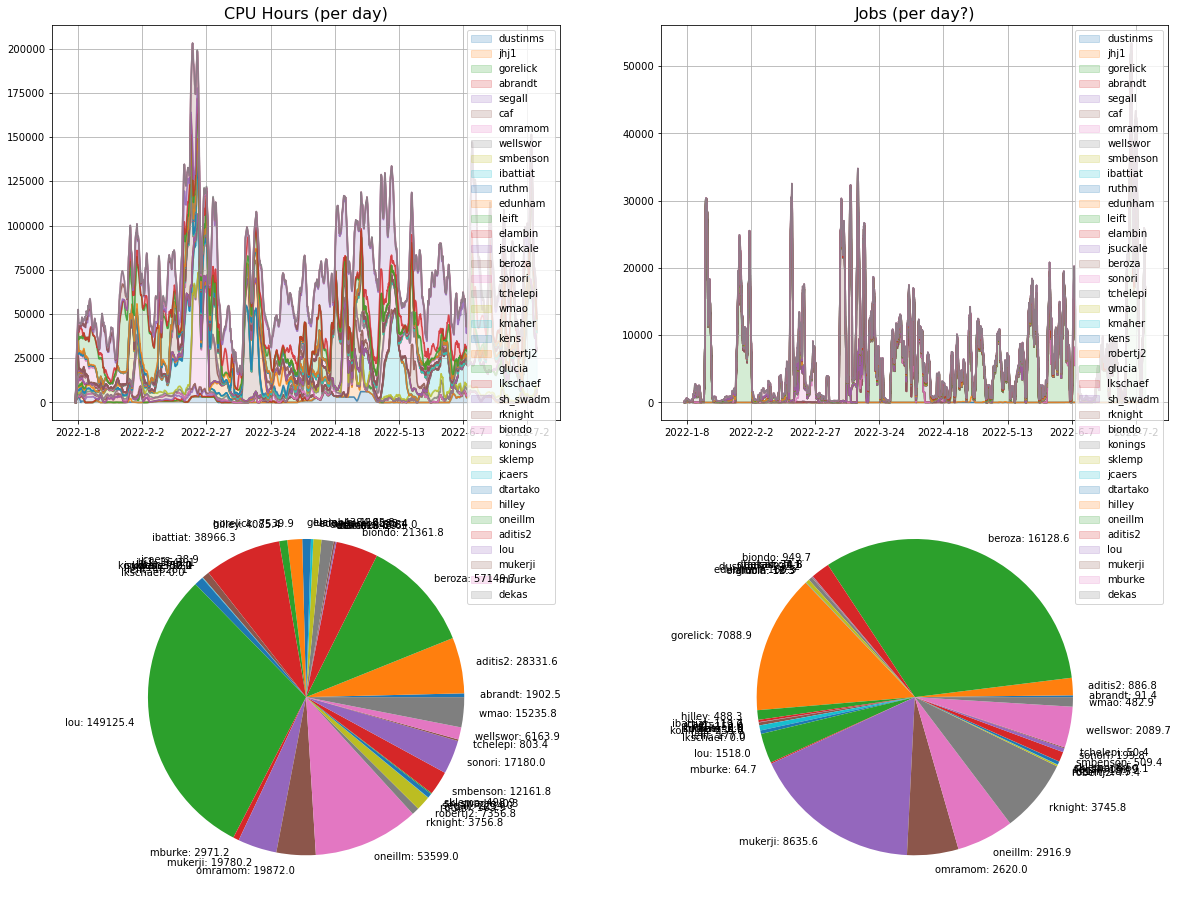

In [38]:
fg = plt.figure(figsize=(20,16))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)
ax1.grid()
ax2.grid()
#
ax1.set_title('CPU Hours (per day)', size=16)
ax2.set_title('Jobs (per day?)', size=16)
#
#cpuh_layers = SACCT_obj.get_cpu_hours_layer_cake(bin_size=1., layer_field='Group')
group_by = 'Group'
cpuh = cpuh_layers['cpu_hours']
jobs = cpuh_layers['jobs']
T = cpuh['time']
#
z_cpuh = hpc_lib.plot_layer_cake(data=cpuh, layers=cpuh.dtype.names[1:], time_col='time', ax=ax1)
z_jobs = hpc_lib.plot_layer_cake(data=jobs, layers=cpuh.dtype.names[1:], time_col='time', ax=ax2)
#
pie_cpuh_data = hpc_lib.plot_pie(sum_data=SACCT_obj['Elapsed']*SACCT_obj['NCPUS'],
                                slice_data=SACCT_obj[group_by], ax=ax3
                                )
#pi_slices = ax.pie(pi_slices[:,1], labels=pi_slices[:,0])
pie_jobs_data = hpc_lib.plot_pie(sum_data=SACCT_obj['Elapsed'], slice_data=SACCT_obj[group_by], 
                            ax=ax4)
#
ax1.legend(loc=0)
ax2.legend(loc=0)
#


/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:3062: UserWarning: FixedFormatter should only be used together with FixedLocator
  def get_pie_slices(sum_data, slice_data, slice_names=None):
/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:3062: UserWarning: FixedFormatter should only be used together with FixedLocator
  def get_pie_slices(sum_data, slice_data, slice_names=None):


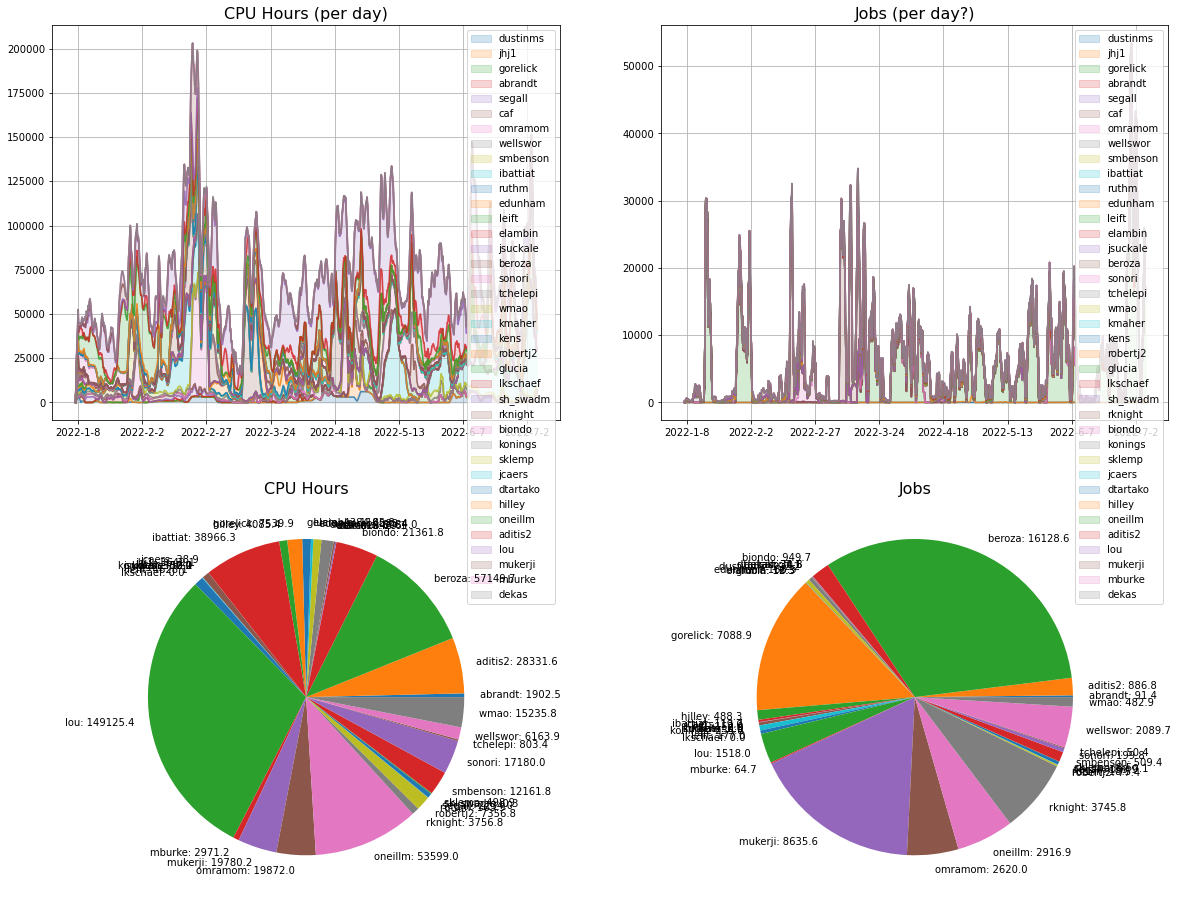

In [45]:
fg = plt.figure(figsize=(20,16))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)

zz = SACCT_obj.report_cpuhours_jobs_layercake_and_pie(fg=fg, cpuh_jobs=cpuh_layers)

In [197]:
acpu_layer_cake = SACCT_obj.get_active_cpus_layer_cake(layer_field='Partition')

*** DEBUG: 5000, None
*** DEBUG: 5000, None
** ** **: t_start, t_end:  [738162.09887731] [738162.22872685]
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None


In [154]:
dt_ep = hpc_lib.compute_mpd_epoch_dt(738150)
print('** ', dt_ep)
print('** ', SACCT_obj.compute_mpd_epoch_dt())
print('** *', hpc_lib.compute_mpd_epoch_dt(dtm.datetime.now()))
#
#print('** ', isinstance(numpy.datetime64(dtm.datetime.now())) )

**  -719163.0
**  -719163.0
** * 0.0


***  [('time', '>f8'), ('ere', '>f8'), ('schroeder', '>f8'), ('temp', '>f8'), ('sep', '>f8'), ('gpu', '>f8'), ('cees', '>f8'), ('suprib', '>f8'), ('clab', '>f8'), ('beroza', '>f8'), ('tgp', '>f8'), ('twohour', '>f8')]
***  [738146.00162037 738146.03762724 738146.07363412 738146.10964099
 738146.14564786 738146.18165473 738146.21766161 738146.25366848
 738146.28967535 738146.32568222]
***  [1512.    0.    0.    0.    0. 2040. 2040. 2040.    0.    0.]


/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:2992: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)
/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:2992: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


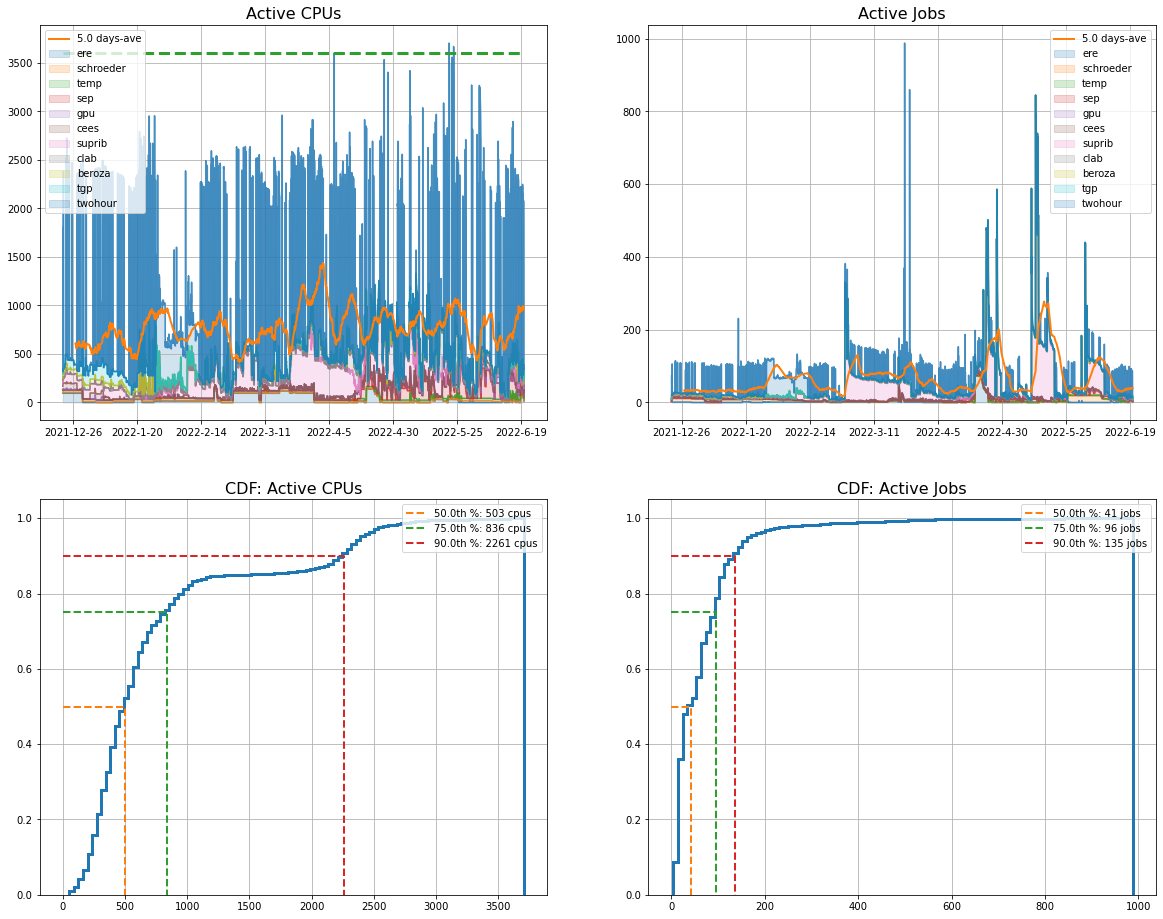

In [158]:
fg = plt.figure(figsize=(20,16))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)
ax1.grid()
ax2.grid()
#
ax1.set_title('Active CPUs', size=16)
ax2.set_title('Active Jobs', size=16)
ax3.set_title('CDF: Active CPUs', size=16)
ax4.set_title('CDF: Active Jobs', size=16)
#
cpus = acpu_layer_cake['N_cpu']
jobs = acpu_layer_cake['N_jobs']
T = cpus['time']
N_max = 150*24.
#
print('*** ', cpus.dtype)
print('*** ', cpus['time'][0:10])
print('*** ', cpus['twohour'][0:10])
#
hpc_lib.plot_layer_cake(data=acpu_layer_cake['N_cpu'], ax=ax1)
hpc_lib.plot_layer_cake(data=acpu_layer_cake['N_jobs'], ax=ax2)
#
# z_cpus = numpy.zeros(len(cpus))
# z_jobs = numpy.zeros(len(jobs))
# for lyr in cpus.dtype.names:
#     if lyr == 'time':
#         continue
#     #
#     z_cpus_prev = z_cpus.copy()
#     z_jobs_prev = z_jobs.copy()
#     dz_cpus = cpus[lyr]
#     dz_jobs = jobs[lyr]
#     #
#     z_cpus += dz_cpus
#     z_jobs += dz_jobs
#     #
#     ln_cpus, = ax1.plot(T, z_cpus, ls='-', alpha=.8)
#     clr = ln_cpus.get_color()
#     ax1.fill_between(T, z_cpus_prev, z_cpus, color=clr, alpha=.2, label=lyr)
#     #
#     ln_jobs, = ax2.plot(T, z_jobs, ls='-', alpha=.8)
#     clr = ln_jobs.get_color()
#     ax2.fill_between(T, z_jobs_prev, z_jobs, color=clr, alpha=.2, label=lyr)
#
# get an ave-len of about a day...
n_days=5.
ave_len = int(numpy.ceil(n_days*len(T)/(T[-1] - T[0])))
#z_cpus = acpu_layer_cake['N_cpu'].dtype.names
z_cpu = ax1.get_lines()[-1].get_ydata()
z_jobs = ax2.get_lines()[-1].get_ydata()
z_cpus_smooth = hpc_lib.running_mean(z_cpu, ave_len)
z_jobs_smooth = hpc_lib.running_mean(z_jobs, ave_len)
#
ax1.plot(T[-len(z_cpus_smooth):], z_cpus_smooth, ls='-', marker='', lw=2, label=f'{n_days} days-ave')
ax2.plot(T[-len(z_jobs_smooth):], z_jobs_smooth, ls='-', marker='', lw=2, label=f'{n_days} days-ave')
#
# # pi charts. left: cpu-hours, right job-time
def f_ix(ky, sacct_obj):
    return [sacct_obj.jobs_summary['Partition']==ky.encode()]
#
# Pie charts aren't really 
# pi_cpus_lbls, pi_cpus_vls = zip(*list({ky:numpy.sum(SACCT_obj.jobs_summary['Elapsed'][f_ix(ky, SACCT_obj)]*SACCT_obj.jobs_summary['NCPUS'][f_ix(ky, SACCT_obj)]) for ky in cpuh.dtype.names[1:]}.items()))
# pi_jobs_lbls, pi_jobs_vls = zip(*list({ky:numpy.sum(SACCT_obj.jobs_summary['Elapsed'][SACCT_obj.jobs_summary['Partition']==ky.encode()]) for ky in cpuh.dtype.names[1:]}.items()))
# # #
# ax3.pie(pi_cpus_vls, labels=pi_cpus_lbls)
# ax4.pie(pi_jobs_vls, labels=pi_jobs_lbls)
#
qs = numpy.array([.5, .75, .9])
qs_cpus = numpy.quantile(z_cpu, qs)
qs_jobs = numpy.quantile(z_jobs, qs)
#
hh_cpus = ax3.hist(z_cpu, bins=100, cumulative=True, density=True, histtype='step', lw=3.)
for x,y in zip(qs_cpus, qs):
    #ax3.plot([0., qs_cpus[-1], qs_cpus[-1]], [qs[-1], qs[-1], 0.], ls='--', color='r', lw=2. )
    ax3.plot([0., x, x], [y, y, 0.], ls='--', lw=2., label=f'{y*100.}th %: {x:.0f} cpus' )
#
hh_jobs = ax4.hist(z_jobs, bins=100, cumulative=True, density=True, histtype='step', lw=3.)
for x,y in zip(qs_jobs, qs):
    #ax3.plot([0., qs_cpus[-1], qs_cpus[-1]], [qs[-1], qs[-1], 0.], ls='--', color='r', lw=2. )
    ax4.plot([0., x, x], [y, y, 0.], ls='--', lw=2., label=f'{y*100.}th %: {x:.0f} jobs' )



#
ax1.plot(T[0::len(T)-1], numpy.ones(2)*N_max, ls='--', lw=3.0  )
#
ax1.legend(loc=0)
ax2.legend(loc=0)
ax3.legend(loc=0)
ax4.legend(loc=0)
#
ax3.grid()
ax4.grid()

# fg.canvas.draw()
# for ax in (ax1, ax2):
#     lbls = [hpc_lib.simple_date_string(mpd.num2date(float(hpc_lib.fix_to_ascii(str(s.get_text())))) ) 
#              for s in ax.get_xticklabels()]
#     ax.set_xticklabels(lbls)
# fg.canvas.draw()



In [26]:
print('*** ', mpd.num2date(738150))
print('*** ', mpd.date2num(dtm.datetime(2022,1,1)))
print('*** ', 3600/24)
#
print('** ', SACCT_obj.jobs_summary.dtype.descr)
print('** cpu_hours capacity: ', 350*24*24)
print('** quantiles_cpu: ', qs_cpus)

***  3990-12-27 00:00:00+00:00
***  18993.0
***  150.0
**  [('index', '<i8'), ('User', ('|S8', {'h5py_encoding': 'ascii'})), ('Group', ('|S5', {'h5py_encoding': 'ascii'})), ('GID', ('|S3', {'h5py_encoding': 'ascii'})), ('JobName', ('|S29', {'h5py_encoding': 'ascii'})), ('JobID', ('|S20', {'h5py_encoding': 'ascii'})), ('JobIDRaw', ('|S7', {'h5py_encoding': 'ascii'})), ('Partition', ('|S9', {'h5py_encoding': 'ascii'})), ('State', ('|S19', {'h5py_encoding': 'ascii'})), ('Timelimit', '<f8'), ('NCPUS', '<i8'), ('NNodes', '<i8'), ('Submit', '<f8'), ('Eligible', '<f8'), ('Start', '<f8'), ('End', '<f8'), ('Elapsed', '<f8'), ('SystemCPU', '<f8'), ('UserCPU', '<f8'), ('TotalCPU', '<f8'), ('NTasks', '<f8'), ('CPUTimeRAW', ('|S9', {'h5py_encoding': 'ascii'})), ('Suspended', ('|S8', {'h5py_encoding': 'ascii'})), ('ReqTRES', ('|S44', {'h5py_encoding': 'ascii'})), ('AllocTRES', ('|S60', {'h5py_encoding': 'ascii'})), ('JobID_parent', ('|S20', {'h5py_encoding': 'ascii'}))]
** cpu_hours capacity:  20160

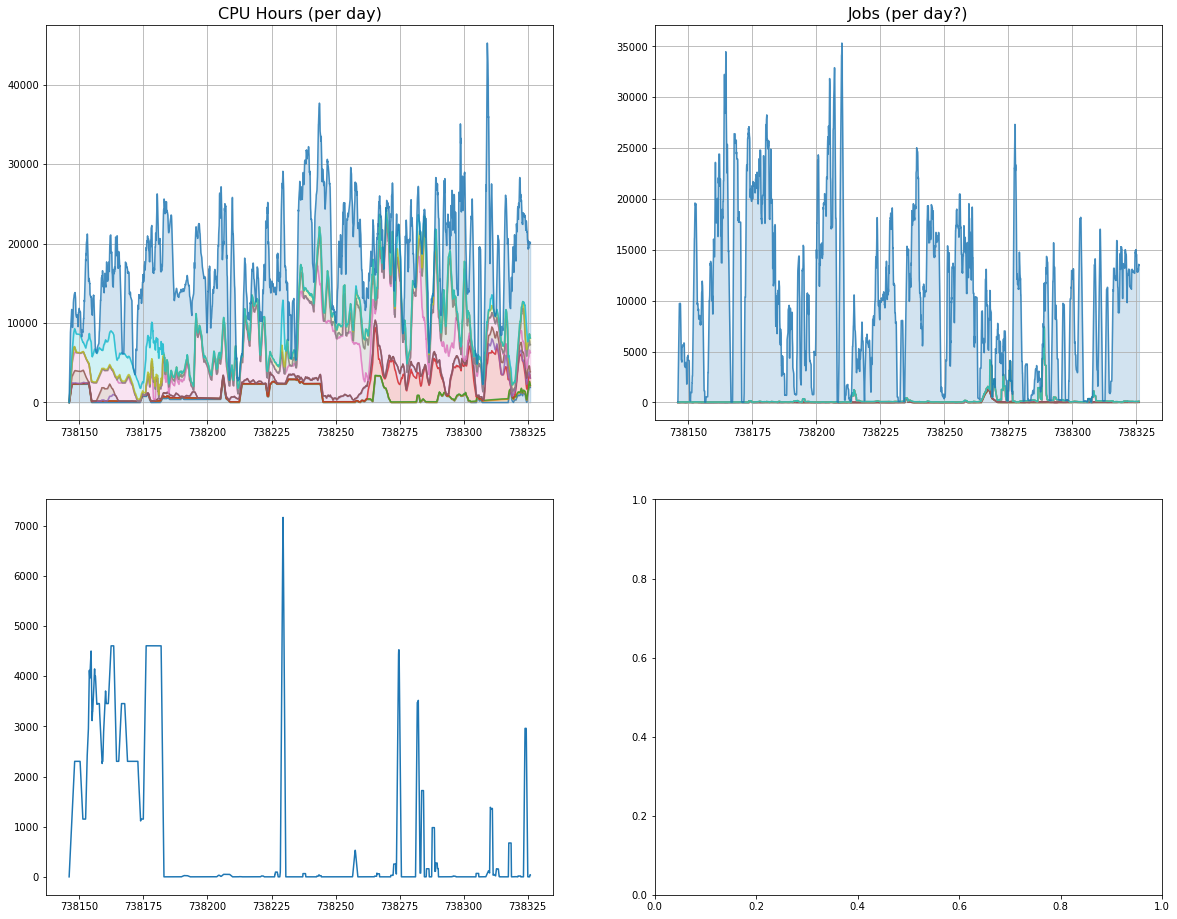

In [135]:
fg = plt.figure(figsize=(20,16))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)
ax1.grid()
ax2.grid()
#
ax1.set_title('CPU Hours (per day)', size=16)
ax2.set_title('Jobs (per day?)', size=16)
#
cpuh = cpuh_layers['cpu_hours']
hpc_lib.plot_layer_cake(data=cpuh_layers['cpu_hours'], ax=ax1)
hpc_lib.plot_layer_cake(data=cpuh_layers['jobs'], ax=ax2)

ax3.plot(cpuh['time'], cpuh['tgp'])

In [31]:
NGPUS = [s.split('gpu=')[1].split(',')[0] if 'gpu=' in s else 0 
         for s in SACCT_obj.jobs_summary['AllocTRES'].astype(str)]

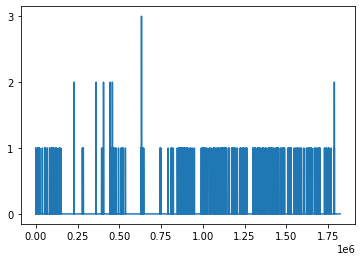

In [34]:
plt.plot(SACCT_obj.get_NGPUs())

### Mazama GPU activity

In [115]:
maz_h5 = 'sacct_data/sacct_pNONE_gNONE_uNone_20211222_20220620.h5'
SACCT_serc = SACCT_obj = hpc_lib.SACCT_data_from_h5(maz_h5, keep_raw_data=False, n_cpu=n_cpus)

# serc_gpu_activity = SACCT_serc.active_jobs_cpu(jobs_summary=None, bin_size=1., 
#                                                NCPUs=SACCT_serc.get_NGPUs())

In [117]:
gpu_layers = SACCT_serc.get_active_cpus_layer_cake(layer_field='Group', NCPUs=SACCT_serc.get_NGPUs())

/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:624: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if NCPUs is None or NCPUs=='':


*** DEBUG: 5000, None


** ['users: 380.2']
** vals:  [380.16340277777743]
*** keys():  dict_keys(['N_cpu', 'N_jobs'])


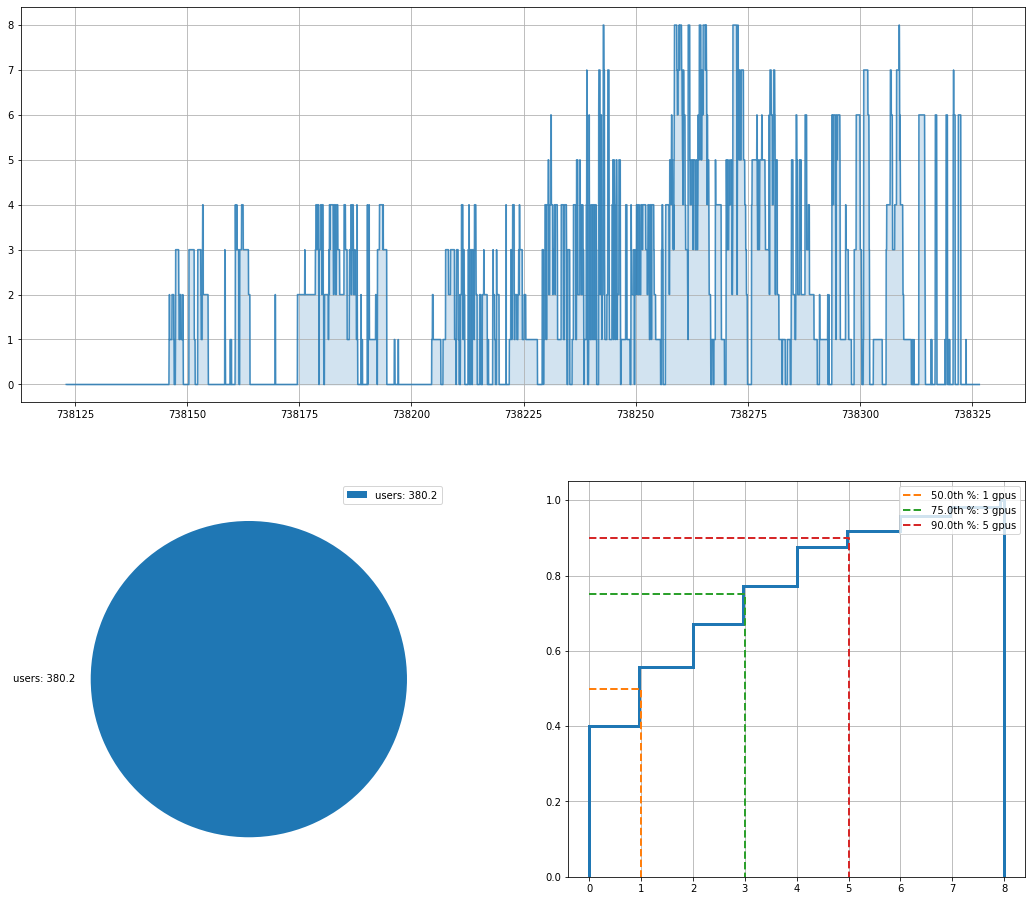

In [121]:
# For MAZAMA
#
pi_gpu_grps = [s for s in gpu_layers['N_cpu'].dtype.names[1:]]
print(f'** {pi_gpu_lbls}' )
#
NGPU = SACCT_serc.get_NGPUs()
#
#pi_gpu_vals = numpy.zeros(len(pi_gpu_lbls))
pi_gpu_vals = []
pi_gpu_lbls = []
for k,g in enumerate(pi_gpu_grps):
    ix = SACCT_serc.jobs_summary['Group'].astype(str)==g
    #
    n_gpus = numpy.sum(SACCT_serc.jobs_summary['Elapsed'][ix] * NGPU[ix])
    if n_gpus <= 0.:
        continue
    #
    pi_gpu_vals += [n_gpus]
    pi_gpu_lbls += [f'{g}: {pi_gpu_vals[-1]:.1f}']
#
print('** vals: ', pi_gpu_vals)
#pi_gpu_lbls = [f'{s}: {v:.1f}' for s,v in zip(pi_gpu_lbls, pi_gpu_vals) ]


fg = plt.figure(figsize=(18,16))
ax1 = fg.add_subplot(2,1,1)
ax2 = fg.add_subplot(2,2,3)
ax3 = fg.add_subplot(2,2,4)
ax1.grid()
#ax2.grid()
ax3.grid()
#
hpc_lib.plot_layer_cake(gpu_layers['N_cpu'], ax=ax1)
z_gpus = ax1.lines[-1].get_ydata()
qs = [.5, .75, .9]
qs_gpu = numpy.quantile(z_gpus, qs)
#
print('*** keys(): ', gpu_layers.keys())
ax2.pie(pi_gpu_vals, labels=pi_gpu_lbls) 
ax2.legend(loc=0)
#
hh_cpus = ax3.hist(z_gpus, bins=100, cumulative=True, density=True, histtype='step', lw=3.)
for x,y in zip(qs_gpu, qs):
    #ax3.plot([0., qs_cpus[-1], qs_cpus[-1]], [qs[-1], qs[-1], 0.], ls='--', color='r', lw=2. )
    ax3.plot([0., x, x], [y, y, 0.], ls='--', lw=2., label=f'{y*100.}th %: {x:.0f} gpus' )

ax1.set_title('Active GPUs', size=16)
ax3.legend(loc=0)

### SERC GPU activity

In [128]:
serc_h5 = 'sacct_data/serc_sacct_20211126_20220525.h5'
SACCT_serc = hpc_lib.SACCT_data_from_h5(serc_h5, keep_raw_data=False, n_cpu=n_cpus)

serc_gpu_activity = SACCT_serc.active_jobs_cpu(jobs_summary=None, bin_size=1., 
                                               NCPUs=SACCT_serc.get_NGPUs())

*** DEBUG: 183, 1.0


In [129]:
gpu_layers = SACCT_serc.get_active_cpus_layer_cake(layer_field='Group', NCPUs=SACCT_serc.get_NGPUs())

*** DEBUG: 5000, None


/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:624: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if NCPUs is None or NCPUs=='':


*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
** ** **: t_start, t_end:  [19048.34990741] [19050.21159722]
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None


** ['users: 380.2']
** vals:  [78.00482638888889, 1116.7903472222222, 0.1394675925925926, 0.2748842592592593, 2203.31869212963, 0.002870370370370371, 181.91452546296296, 327.7860648148148, 1.6576157407407408, 63.74034722222222, 12.820648148148148]
*** keys():  dict_keys(['N_cpu', 'N_jobs'])


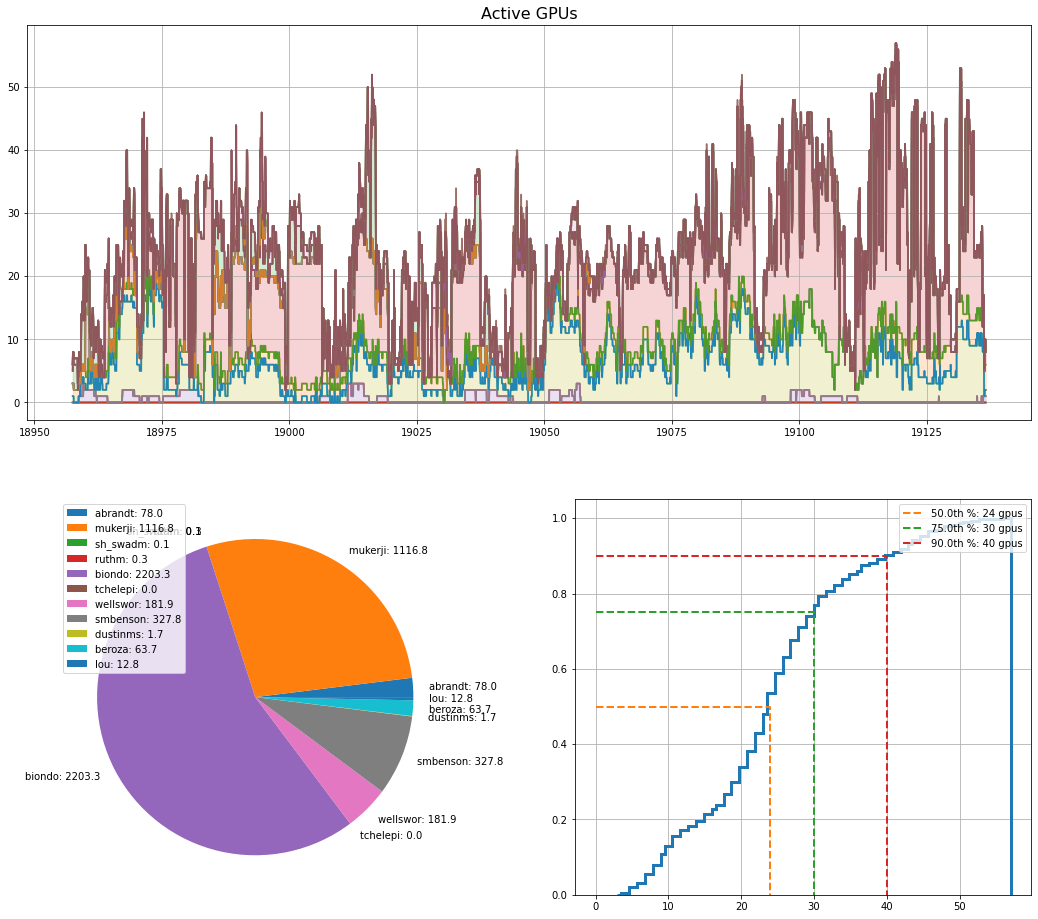

In [130]:
pi_gpu_grps = [s for s in gpu_layers['N_cpu'].dtype.names[1:]]
print(f'** {pi_gpu_lbls}' )
#
NGPU = SACCT_serc.get_NGPUs()
#
#pi_gpu_vals = numpy.zeros(len(pi_gpu_lbls))
pi_gpu_vals = []
pi_gpu_lbls = []
for k,g in enumerate(pi_gpu_grps):
    ix = SACCT_serc.jobs_summary['Group'].astype(str)==g
    #
    n_gpus = numpy.sum(SACCT_serc.jobs_summary['Elapsed'][ix] * NGPU[ix])
    if n_gpus <= 0.:
        continue
    #
    pi_gpu_vals += [n_gpus]
    pi_gpu_lbls += [f'{g}: {pi_gpu_vals[-1]:.1f}']
#
print('** vals: ', pi_gpu_vals)
#pi_gpu_lbls = [f'{s}: {v:.1f}' for s,v in zip(pi_gpu_lbls, pi_gpu_vals) ]


fg = plt.figure(figsize=(18,16))
ax1 = fg.add_subplot(2,1,1)
ax2 = fg.add_subplot(2,2,3)
ax3 = fg.add_subplot(2,2,4)
ax1.grid()
#ax2.grid()
ax3.grid()
#
hpc_lib.plot_layer_cake(gpu_layers['N_cpu'], ax=ax1)
z_gpus = ax1.lines[-1].get_ydata()
qs = [.5, .75, .9]
qs_gpu = numpy.quantile(z_gpus, qs)
#
print('*** keys(): ', gpu_layers.keys())
ax2.pie(pi_gpu_vals, labels=pi_gpu_lbls) 
ax2.legend(loc=0)
#
hh_cpus = ax3.hist(z_gpus, bins=100, cumulative=True, density=True, histtype='step', lw=3.)
for x,y in zip(qs_gpu, qs):
    #ax3.plot([0., qs_cpus[-1], qs_cpus[-1]], [qs[-1], qs[-1], 0.], ls='--', color='r', lw=2. )
    ax3.plot([0., x, x], [y, y, 0.], ls='--', lw=2., label=f'{y*100.}th %: {x:.0f} gpus' )

ax1.set_title('Active GPUs', size=16)
ax3.legend(loc=0)


In [131]:
print('** ', gpu_layers['N_cpu'].dtype.names)

**  ('time', 'wmao', 'dtartako', 'leift', 'mlapotre', 'abrandt', 'hilley', 'jsuckale', 'omramom', 'mukerji', 'sklemp', 'edunham', 'sh_swadm', 'ruthm', 'biondo', 'rknight', 'sonori', 'robertj2', 'jhj1', 'kens', 'oneillm', 'tchelepi', 'gorelick', 'wellswor', 'dekas', 'jcaers', 'konings', 'smbenson', 'aditis2', 'dustinms', 'glucia', 'elambin', 'ibattiat', 'beroza', 'mburke', 'segall', 'lou')


In [132]:
cpu_jobs_serc = SACCT_serc.active_jobs_cpu()


*** DEBUG: 5000, None


In [133]:
serc_cpu_qs = numpy.quantile(cpu_jobs_serc['N_cpu'], [.5, .75, .9])
print('** qs: ', serc_cpu_qs)

** qs:  [2511.5 3336.5 4105.1]


<ipython-input-141-2d0f7349995f>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(lbls)


[Text(738125.0, 0, '2021-12-1'),
 Text(738150.0, 0, '2021-12-26'),
 Text(738175.0, 0, '2022-1-20'),
 Text(738200.0, 0, '2022-2-14'),
 Text(738225.0, 0, '2022-3-11'),
 Text(738250.0, 0, '2022-4-5'),
 Text(738275.0, 0, '2022-4-30'),
 Text(738300.0, 0, '2022-5-25'),
 Text(738325.0, 0, '2022-6-19'),
 Text(738350.0, 0, '2022-7-14')]

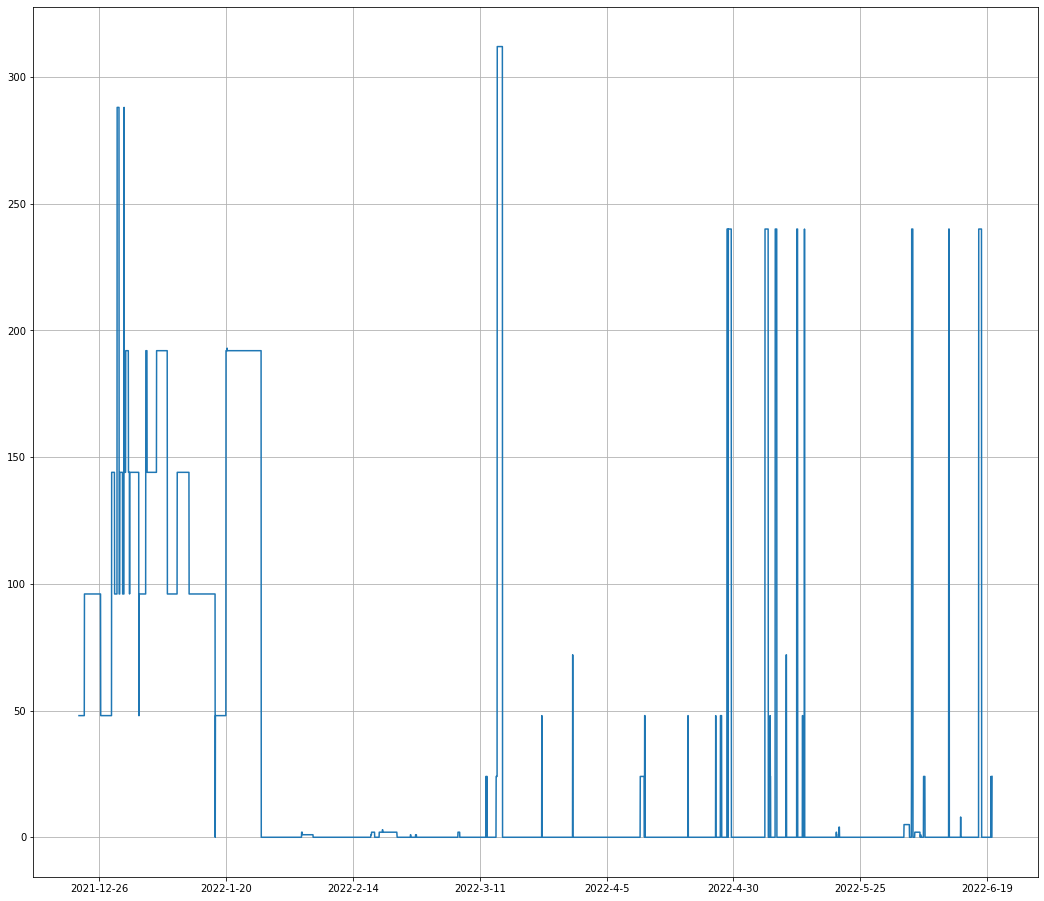

In [141]:
acpu = acpu_layer_cake['N_cpu']
fg = plt.figure(figsize=(18,16))
ax1 = fg.add_subplot(1,1,1)
#
ax1.grid()
ax1.plot(acpu['time'], acpu['tgp'])

fg.canvas.draw()
#lbls = [hpc_lib.simple_date_string(mpd.num2date(float(hpc_lib.fix_to_ascii(str(s.get_text()))) - hpc_lib.dt_mpd_epoch) ) 
#         for s in ax1.get_xticklabels()]
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(hpc_lib.fix_to_ascii(str(s.get_text()))) + SACCT_obj.dt_mpd_epoch) ) 
         for s in ax1.get_xticklabels()]
ax1.set_xticklabels(lbls)


In [214]:
print('*** ', SACCT_serc.jobs_summary.dtype)

***  [('index', '<i8'), ('User', 'S8'), ('Group', 'S8'), ('GID', 'S6'), ('JobName', 'S81'), ('JobID', 'S67'), ('JobIDRaw', 'S8'), ('Partition', 'S4'), ('State', 'S19'), ('Timelimit', '<f8'), ('NCPUS', '<i8'), ('NNodes', '<i8'), ('Submit', '<f8'), ('Eligible', '<f8'), ('Start', '<f8'), ('End', '<f8'), ('Elapsed', '<f8'), ('SystemCPU', '<f8'), ('UserCPU', '<f8'), ('TotalCPU', '<f8'), ('NTasks', '<f8'), ('CPUTimeRAW', 'S9'), ('Suspended', 'S8'), ('ReqTRES', 'S48'), ('AllocTRES', 'S61'), ('JobID_parent', 'S67')]


In [228]:
print('*** ', hpc_lib.kmg_to_num('105k'))
print('** ', [hpc_lib.kmg_to_num(s) for s in ['11k', '11m', '11M', '11g']])
print('** ', [hpc_lib.kmg_to_num(s) for s in ['11', '11.3', '', 's']])

***  105000.0
**  [11000.0, 11000000.0, 11000000.0, 11000000000.0]
**  [11.0, 11.3, None, None]


In [13]:
print('** ', SACCT_obj.jobs_summary.dtype.names)

**  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize', 'MaxDiskWrite', 'MaxDiskRead', 'AveDiskWrite', 'AveDiskRead', 'JobID_parent')


**  0


ValueError: autodetected range of [nan, nan] is not finite

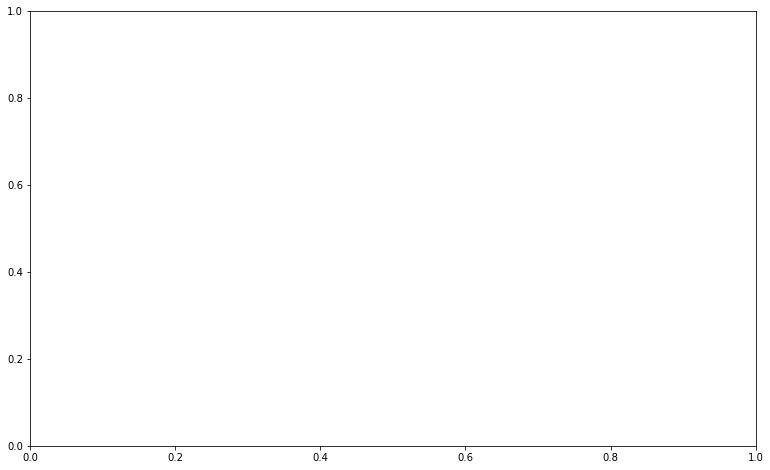

In [22]:
fg = plt.figure(figsize=(13,8))
ax = fg.add_subplot(1,1,1)
#
print('** ', numpy.sum([not numpy.isnan(x) for x in SACCT_obj.jobs_summary['MaxRSS']]))
hh = ax.hist(SACCT_obj.jobs_summary['MaxRSS'], bins=100, histtype='step', cumulative=True)

In [229]:
os.system('hostname')

0

In [230]:
import socket
socket.gethostname()

'UIT-C02YT0LBLVDP.local'